<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fine-tuning an Action Recognition Model on HMDB51

In this notebook, we demonstrate how to get the SOTA results for the [HMDB51](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/) human action dataset using the R(2+1)D model.

## Initialization

Import all the functions we need

In [1]:
import sys
sys.path.append("../../")
import time
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision

from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.action_recognition.dataset import VideoRecord, VideoDataset
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path

system_info()

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters.

In [3]:
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8
# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8
# Number of training epochs
EPOCHS = 1

And specify where you downloaded HMDB51.

In [4]:
DATA_ROOT = os.path.join(str(data_path()), "misc/hmdb51")
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")

For this notebook, we'll try to reproduce the SOTA results on HMDB51 using a specific train/test split known simply as "split1". Download the split and specify where the download location.

In [5]:
TRAIN_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_train_split_1.txt")
TEST_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_val_split_1.txt")

---

# Prepare HMDB51 using the Video Dataset

We can load the downloaded HMBD51 dataset into our `VideoDataset` class by simply passing it the location of the folder. However, since we'll want to specifically test on "split1", we'll also want to pass it train and test reference files.

Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

In [6]:
data = VideoDataset(
    VIDEO_DIR,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    sample_length=MODEL_INPUT_SIZE,
    video_ext="avi",
)

Now that the data is loaded, we can take a quick look at some samples.

/home/jiata/anaconda3/envs/cv/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<Figure size 432x288 with 0 Axes>

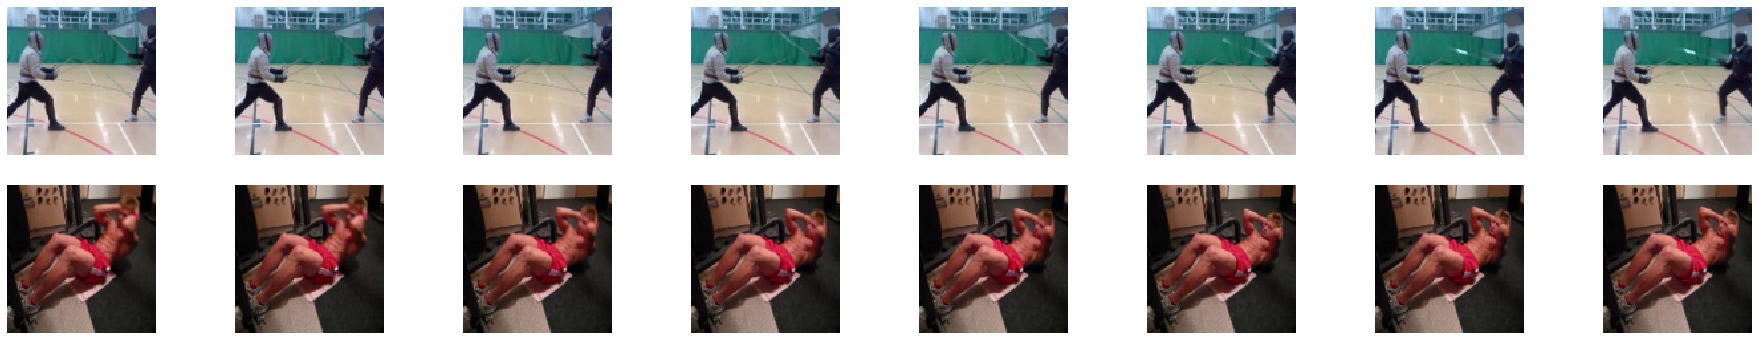

In [7]:
data.show_batch(rows=2)

Lets also take a look at the (default) parameters that we're using:

In [8]:
print(f"""\
sample_length: {data.sample_length}
sample_step: {data.sample_step}
temporal_jitter: {data.temporal_jitter}
temporal_jitter_step: {data.temporal_jitter_step}
random_shift: {data.random_shift}
""")

sample_length: 8
sample_step: 1
temporal_jitter: True
temporal_jitter_step: 2
random_shift: True



## Setup the Video Learner

In [9]:
learner = VideoLearner(data, num_classes=51)

Loading r2plus1d_34_8_ig65m model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [10]:
learner.model.fc

Linear(in_features=512, out_features=51, bias=True)

In [11]:
learner.dataset.train_ds.dataset.video_records[0].label

13

In [12]:
# Training configuration
train_cfgs = dict(
    epochs=EPOCHS,  # Number of training epochs
    lr=0.0001,  # Learning rate
    lr_step_size=np.ceil(
        2 / 3 * EPOCHS
    ),  # Reduce learning rate by factor of 10 after this many epochs.
    # No need to change these parameters
    grad_steps=2,  # Accumulate the gradients over multiple forward passes
    mixed_prec=False,  # Use mixed precision to speed up training
)

In [13]:
learner.fit(train_cfgs)

Params to learn:
	full network
Epoch 1 ==========
lr=[0.0001]
train took 214.37 sec: loss = 3.6582, top1_acc = 19.4398, top5_acc = 39.4118
valid took 63.56 sec: loss = 3.1017, top1_acc = 30.2614, top5_acc = 56.4052


## Model Test

Reported accuracy from "Closer look" paper: 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo)

1. sample 10 clips uniformly sampled from each test video: [10 x 3 x (8 or 32) x 112 x 112]
2. calculate clip-level accuracy: Use 10 batch and infer
3. calculate video-level accuracy by averaging them
4. average over the clips

In [14]:
# ### Load Saved Weights if needed
#learn.load(body_train_cfgs['model_name'] + "_032", body_train_cfgs['model_dir'])

In [15]:
if cuda.is_available():
    device = torch.device("cuda")
    num_gpus = cuda.device_count()
    # Look for the optimal set of algorithms to use in cudnn. Use this only with fixed-size inputs.
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    num_gpus = 0

In [16]:
learner.dataset.test_ds.dataset.num_samples = 10

In [17]:
print(
    f"{len(learner.dataset.test_ds)} samples of {learner.dataset.test_ds[0][0][0].shape}"
)

1530 samples of torch.Size([3, 8, 112, 112])


In [18]:
# Initialize the model
model = learner.model
model.to(device)
if num_gpus > 1:
    model = nn.DataParallel(model)
model.eval()

# Loop over all examples in the test set and compute accuracies
infer_times = []
video_preds = []
video_trues = []
clip_preds = []
clip_trues = []
report_every = 100

with torch.no_grad():
    for i in range(
        1, len(learner.dataset.test_ds)
    ):  # [::10]:  # Skip some examples to speed up accuracy computation
        if i % report_every == 0:
            print(
                "Processsing {} of {} samples..".format(i, len(learner.dataset.test_ds))
            )

        # Get model inputs
        inputs, label = learner.dataset.test_ds[i]
        inputs = inputs.to(device, non_blocking=True)

        # Run inference
        start_time = time.time()
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()
        infer_time = time.time() - start_time
        infer_times.append(infer_time)

        # Store results
        video_preds.append(outputs.sum(axis=0).argmax())
        video_trues.append(label)
        clip_preds.extend(outputs.argmax(axis=1))
        clip_trues.extend([label] * learner.dataset.test_ds.dataset.num_samples)

print(
    "Avg. inference time per video (10 clips) =",
    np.array(infer_times).mean() * 1000,
    "ms",
)
print("Video prediction accuracy =", accuracy_score(video_trues, video_preds))
print("Clip prediction accuracy =", accuracy_score(clip_trues, clip_preds))

Processsing 100 of 1530 samples..
Processsing 200 of 1530 samples..
Processsing 300 of 1530 samples..
Processsing 400 of 1530 samples..
Processsing 500 of 1530 samples..
Processsing 600 of 1530 samples..
Processsing 700 of 1530 samples..
Processsing 800 of 1530 samples..
Processsing 900 of 1530 samples..
Processsing 1000 of 1530 samples..
Processsing 1100 of 1530 samples..
Processsing 1200 of 1530 samples..
Processsing 1300 of 1530 samples..
Processsing 1400 of 1530 samples..
Processsing 1500 of 1530 samples..
Avg. inference time per video (10 clips) = 93.1767484890705 ms
Video prediction accuracy = 0.31000654022236757
Clip prediction accuracy = 0.29888816219751474
